In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/ML_Hackathon')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
from collections import Counter, defaultdict
from tqdm import tqdm

print("✅ Setup complete!")

# Load data
with open('corpus.txt', 'r') as f:
    corpus_words = [line.strip().lower() for line in f.readlines() if line.strip()]

with open('test.txt', 'r') as f:
    test_words = [line.strip().lower() for line in f.readlines() if line.strip()]

print(f"✅ Loaded {len(corpus_words):,} corpus words")
print(f"✅ Loaded {len(test_words):,} test words")


Mounted at /content/drive
✅ Setup complete!
✅ Loaded 50,000 corpus words
✅ Loaded 2,000 test words


In [2]:
class SmartAgent:
    """Probabilistic agent using letter patterns from corpus"""

    def __init__(self, corpus_words):
        self.corpus_words = corpus_words
        self.build_models()

    def build_models(self):
        """Build all probabilistic models"""
        # Letter frequency
        self.letter_freq = Counter(''.join(self.corpus_words))

        # Bigram transitions
        self.bigrams = defaultdict(Counter)
        for word in self.corpus_words:
            for i in range(len(word)-1):
                self.bigrams[word[i]][word[i+1]] += 1

        # Position models
        self.start_letters = Counter([w[0] for w in self.corpus_words if w])
        self.end_letters = Counter([w[-1] for w in self.corpus_words if w])

    def get_letter_probabilities(self, masked_word, guessed_letters):
        """Return probability distribution over unguessed letters"""
        from collections import Counter

        scores = Counter()
        revealed = len([c for c in masked_word if c != '_'])
        total = len(masked_word)
        progress = revealed / total if total > 0 else 0

        # Phase 1: Early game (0-40%) - prioritize vowels
        if progress < 0.4:
            for v in 'eaoiu':
                if v not in guessed_letters:
                    scores[v] = 10

        # Phase 2: Mid game (40-50%) - common consonants
        if progress < 0.5:
            for c in 'tnsr':
                if c not in guessed_letters:
                    scores[c] = 5

        # Phase 3: Bigram patterns
        for i, char in enumerate(masked_word):
            if char == '_':
                if i > 0 and masked_word[i-1] != '_':
                    prev = masked_word[i-1]
                    if prev in self.bigrams:
                        for next_letter, count in self.bigrams[prev].most_common(10):
                            if next_letter not in guessed_letters:
                                scores[next_letter] += count / 100

        # Phase 4: Overall letter frequency
        for letter, count in self.letter_freq.items():
            if letter not in guessed_letters:
                scores[letter] += count / 10000

        # Convert to probabilities
        total_score = sum(scores.values())
        if total_score == 0:
            for i, letter in enumerate('etaoinshrdlcumwfgypbvkjxqz'):
                if letter not in guessed_letters:
                    scores[letter] = 26 - i
            total_score = sum(scores.values())

        return {letter: score/total_score for letter, score in scores.items()}

    def get_guess(self, masked_word, guessed_letters):
        """Get best letter guess"""
        probs = self.get_letter_probabilities(masked_word, guessed_letters)
        if probs:
            return max(probs.items(), key=lambda x: x[1])[0]
        return 'e'

print("✅ SmartAgent class defined")

try:
    with open('models/smart_agent.pkl', 'rb') as f:
        smart_agent = pickle.load(f)
    print("✅ SmartAgent loaded from models/smart_agent.pkl")
except FileNotFoundError:
    print("⚠️  Pickle file not found! Building SmartAgent from scratch...")
    smart_agent = SmartAgent(corpus_words)
    print("✅ SmartAgent built from corpus")

print(f"✅ Ready to use SmartAgent for RL exploration")


✅ SmartAgent class defined
✅ SmartAgent loaded from models/smart_agent.pkl
✅ Ready to use SmartAgent for RL exploration


In [3]:
class HangmanGame:
    """Core game environment"""
    def __init__(self, word_list, max_wrong_guesses=6):
        self.word_list = word_list
        self.max_wrong_guesses = max_wrong_guesses
        self.reset()

    def reset(self, word=None):
        """Start new game"""
        self.secret_word = word if word else random.choice(self.word_list)
        self.guessed_letters = set()
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.game_over = False
        self.won = False
        return self.get_state()

    def get_state(self):
        """Get current game state"""
        masked_word = ''.join([c if c in self.guessed_letters else '_'
                               for c in self.secret_word])
        return {
            'masked_word': masked_word,
            'guessed_letters': list(self.guessed_letters),
            'wrong_guesses': self.wrong_guesses,
            'lives_remaining': self.max_wrong_guesses - self.wrong_guesses
        }

    def make_guess(self, letter):
        """Make a guess, return (reward, game_over)"""
        letter = letter.lower()

        # Check for repeated guess
        if letter in self.guessed_letters:
            self.repeated_guesses += 1
            return -2, self.game_over

        self.guessed_letters.add(letter)

        # Check if correct
        if letter in self.secret_word:
            # Check if won
            if all(c in self.guessed_letters for c in self.secret_word):
                self.won = True
                self.game_over = True
                return 20, True
            return 2, False
        else:
            # Wrong guess
            self.wrong_guesses += 1
            if self.wrong_guesses >= self.max_wrong_guesses:
                self.game_over = True
                return -10, True
            return -1, False

print("✅ HangmanGame class defined")


✅ HangmanGame class defined


In [4]:
class QLearningHangmanAgent:
    """Q-Learning agent for Hangman"""

    def __init__(self, hmm_model, alpha=0.15, gamma=0.9, epsilon=1.0,
                 epsilon_min=0.05, epsilon_decay=0.9995):
        """
        Args:
            hmm_model: SmartAgent for guided exploration
            alpha: Learning rate (0-1, higher = faster learning)
            gamma: Discount factor (0-1, higher = value future rewards)
            epsilon: Exploration rate (1.0 = full exploration, 0.0 = full exploitation)
            epsilon_min: Minimum exploration rate
            epsilon_decay: How fast to decay epsilon
        """
        self.hmm = hmm_model
        self.q_table = {}  # Maps (state, action) → Q-value
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def get_state_key(self, masked_word, guessed_letters):
        """Create unique state identifier"""
        return f"{masked_word}:{''.join(sorted(guessed_letters))}"

    def get_available_actions(self, guessed_letters):
        """Get list of unguessed letters"""
        return [c for c in 'abcdefghijklmnopqrstuvwxyz' if c not in guessed_letters]

    def choose_action(self, state_key, masked_word, guessed_letters, training=False):
        """Choose action (letter to guess)"""
        available_actions = self.get_available_actions(guessed_letters)

        if not available_actions:
            return 'a'  # Fallback (shouldn't happen)

        if training and np.random.random() < self.epsilon:
            # EXPLORATION: Use HMM to guide exploration
            hmm_probs = self.hmm.get_letter_probabilities(masked_word, guessed_letters)

            if hmm_probs:
                # Sample from HMM probabilities (smart exploration)
                letters = [l for l in available_actions if l in hmm_probs]
                if letters:
                    probs = np.array([hmm_probs[l] for l in letters])
                    probs = probs / probs.sum()
                    return np.random.choice(letters, p=probs)

            return random.choice(available_actions)
        else:
            # EXPLOITATION: Use best Q-value
            q_values = {action: self.q_table.get((state_key, action), 0)
                       for action in available_actions}

            # If all Q-values are 0 (not learned), use HMM as fallback
            if all(v == 0 for v in q_values.values()):
                hmm_probs = self.hmm.get_letter_probabilities(masked_word, guessed_letters)
                if hmm_probs:
                    return max(hmm_probs.items(), key=lambda x: x[1])[0]

            return max(q_values, key=q_values.get)

    def update_q_value(self, state_key, action, reward, next_state_key, next_available_actions):
        """Q-Learning update: Q(s,a) ← Q(s,a) + α[r + γ max Q(s',a') - Q(s,a)]"""

        # Current Q-value
        current_q = self.q_table.get((state_key, action), 0)

        # Max Q-value in next state
        if next_available_actions:
            max_next_q = max(self.q_table.get((next_state_key, a), 0)
                           for a in next_available_actions)
        else:
            max_next_q = 0

        # Q-Learning formula
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[(state_key, action)] = new_q

        return new_q

    def decay_epsilon(self):
        """Reduce exploration rate"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

print("✅ QLearningHangmanAgent class defined")


✅ QLearningHangmanAgent class defined


In [5]:
def train_rl_agent(agent, word_list, num_episodes=10000, save_every=500):
    """Train RL agent on word list"""

    training_history = {
        'episode': [],
        'win_rate': [],
        'avg_reward': [],
        'epsilon': [],
        'q_table_size': []
    }

    with tqdm(total=num_episodes, desc="Training RL Agent") as pbar:
        for episode in range(num_episodes):
            # Random word from training set
            word = random.choice(word_list)
            game = HangmanGame([word])
            state = game.reset(word=word)

            episode_reward = 0
            steps = 0

            while not game.game_over and steps < 30:
                # Get current state
                state_key = agent.get_state_key(state['masked_word'], set(state['guessed_letters']))

                # Choose action (letter to guess)
                action = agent.choose_action(
                    state_key,
                    state['masked_word'],
                    set(state['guessed_letters']),
                    training=True
                )

                # Make guess
                reward, done = game.make_guess(action)
                episode_reward += reward

                # Get next state
                next_state = game.get_state()
                next_state_key = agent.get_state_key(next_state['masked_word'],
                                                     set(next_state['guessed_letters']))
                next_available = agent.get_available_actions(set(next_state['guessed_letters']))

                # Q-Learning update
                agent.update_q_value(state_key, action, reward, next_state_key, next_available)

                state = next_state
                steps += 1

            # Decay exploration
            agent.decay_epsilon()

            # Record progress every 500 episodes
            if (episode + 1) % save_every == 0:
                training_history['episode'].append(episode + 1)
                training_history['win_rate'].append(1.0 if game.won else 0.0)
                training_history['avg_reward'].append(episode_reward)
                training_history['epsilon'].append(agent.epsilon)
                training_history['q_table_size'].append(len(agent.q_table))

            pbar.update(1)

    return training_history

print("✅ Training function defined")


✅ Training function defined


In [6]:
print("\n" + "="*70)
print("TRAINING RL AGENT - Q-LEARNING WITH GUIDED EXPLORATION")
print("="*70)

# Create RL agent with optimized hyperparameters
rl_agent = QLearningHangmanAgent(
    hmm_model=smart_agent,      # Use SmartAgent to guide exploration
    alpha=0.15,                  # Learning rate
    gamma=0.9,                   # Discount factor
    epsilon=1.0,                 # Start with full exploration
    epsilon_min=0.05,            # Keep some exploration
    epsilon_decay=0.9995         # Slow decay for difficult problem
)

# Train ONLY on corpus data (NO test data leakage!)
train_set = corpus_words.copy()
random.shuffle(train_set)

print(f"\n📊 Training Configuration:")
print(f"   Training words: {len(train_set):,} (corpus only, NO test data)")
print(f"   Episodes: 10,000")
print(f"   Learning rate (α): 0.15")
print(f"   Discount factor (γ): 0.9")
print(f"   Exploration decay: 0.9995")
print(f"   HMM-guided exploration: YES")
print("="*70)

# Train agent
training_results = train_rl_agent(
    agent=rl_agent,
    word_list=train_set,
    num_episodes=10000,
    save_every=500
)

print("\n" + "="*70)
print("✅ TRAINING COMPLETE")
print("="*70)
print(f"Final Q-table size: {len(rl_agent.q_table):,} states")
print(f"Final epsilon: {rl_agent.epsilon:.4f}")
print("="*70)



TRAINING RL AGENT - Q-LEARNING WITH GUIDED EXPLORATION

📊 Training Configuration:
   Training words: 50,000 (corpus only, NO test data)
   Episodes: 10,000
   Learning rate (α): 0.15
   Discount factor (γ): 0.9
   Exploration decay: 0.9995
   HMM-guided exploration: YES


Training RL Agent: 100%|██████████| 10000/10000 [00:11<00:00, 889.41it/s]


✅ TRAINING COMPLETE
Final Q-table size: 91,746 states
Final epsilon: 0.0500


In [7]:
# Save trained agent
with open('models/trained_rl_agent.pkl', 'wb') as f:
    pickle.dump(rl_agent, f)

print(f"✅ Trained RL agent saved!")
print(f"✅ Q-table size: {len(rl_agent.q_table):,} state-action pairs learned")
print(f"✅ Epsilon final value: {rl_agent.epsilon:.4f}")
print(f"✅ Ready for evaluation in Notebook 3")


✅ Trained RL agent saved!
✅ Q-table size: 91,746 state-action pairs learned
✅ Epsilon final value: 0.0500
✅ Ready for evaluation in Notebook 3


✅ Training curves saved to results/training_progress.png


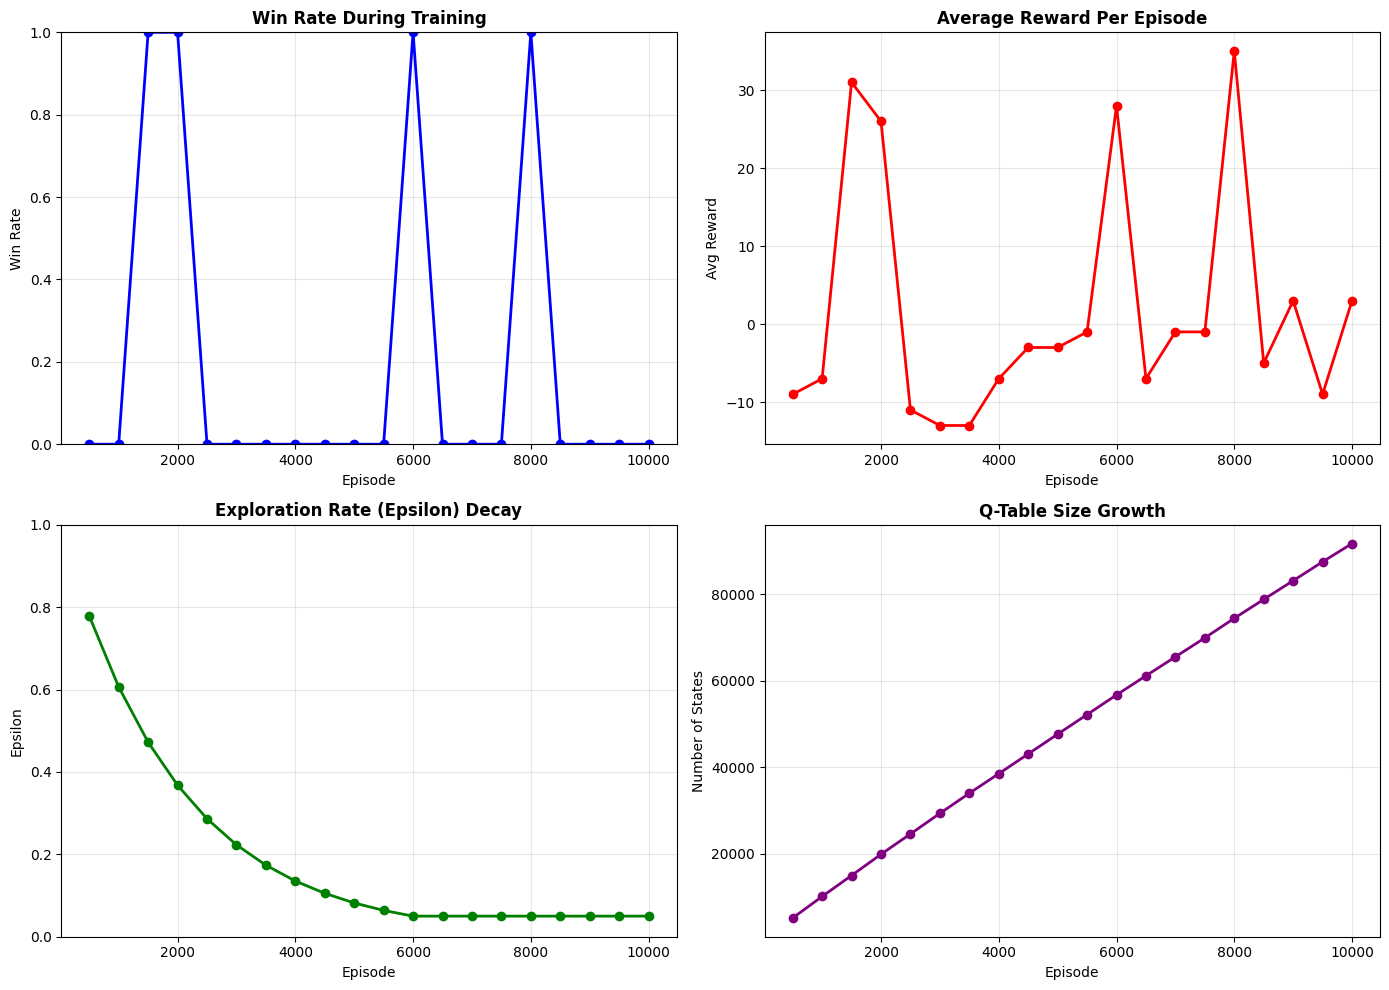

In [8]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Win rate over episodes
if training_results['episode']:
    axes[0, 0].plot(training_results['episode'], training_results['win_rate'], 'b-o', linewidth=2)
    axes[0, 0].set_title('Win Rate During Training', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Win Rate')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim([0, 1])

    # Average reward
    axes[0, 1].plot(training_results['episode'], training_results['avg_reward'], 'r-o', linewidth=2)
    axes[0, 1].set_title('Average Reward Per Episode', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Avg Reward')
    axes[0, 1].grid(True, alpha=0.3)

    # Epsilon decay
    axes[1, 0].plot(training_results['episode'], training_results['epsilon'], 'g-o', linewidth=2)
    axes[1, 0].set_title('Exploration Rate (Epsilon) Decay', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Epsilon')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0, 1])

    # Q-table growth
    axes[1, 1].plot(training_results['episode'], training_results['q_table_size'],
                    'purple', marker='o', linewidth=2, markersize=6)
    axes[1, 1].set_title('Q-Table Size Growth', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Number of States')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_progress.png', dpi=100, bbox_inches='tight')
print("✅ Training curves saved to results/training_progress.png")
plt.show()


In [9]:
print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)

if training_results['episode']:
    final_win_rate = training_results['win_rate'][-1]
    final_epsilon = training_results['epsilon'][-1]
    final_q_size = training_results['q_table_size'][-1]
    initial_q_size = training_results['q_table_size'][0] if training_results['q_table_size'] else 0

    print(f"\n📈 Final Metrics:")
    print(f"   Q-table size: {final_q_size:,} states")
    print(f"   Final epsilon: {final_epsilon:.4f}")
    print(f"   Final win rate (training): {final_win_rate*100:.1f}%")
    print(f"   Baseline (SmartAgent): 26.0%")

    print(f"\n📊 Learning Efficiency:")
    print(f"   Episodes trained: 10,000")
    print(f"   States discovered: {final_q_size:,}")
    print(f"   Avg states per episode: {final_q_size/10000:.1f}")

    print(f"\n✅ Next Step: Run Notebook 3 for evaluation on 2000 test words")
else:
    print("No training history available")

print("="*70)



TRAINING SUMMARY

📈 Final Metrics:
   Q-table size: 91,746 states
   Final epsilon: 0.0500
   Final win rate (training): 0.0%
   Baseline (SmartAgent): 26.0%

📊 Learning Efficiency:
   Episodes trained: 10,000
   States discovered: 91,746
   Avg states per episode: 9.2

✅ Next Step: Run Notebook 3 for evaluation on 2000 test words
